# Stock Prediction Data

## Introduction
  * Supervised Learning Stock Prediction

## Load data

- use the getStockYF program to download stock data from Intrinio

In [92]:
import pandas as pd
import numpy as np
import datetime as dt
import requests
from io import StringIO
from IntrinioApiCredentials import *
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_graphviz
%matplotlib inline

# Paramters

ticker = "^GSPC"    
source='file' # ... doesn't matter
dataStartDate=dt.datetime(1990,1,1)  # 1990-01-01 ^GSPC Yahoo 
                     #... 2007-1-1 Intrinio ... need to give chance for nan to clear
today = dt.date.today()
startDate=str(dataStartDate.year)+'-'+str(dataStartDate.month)+'-'+str(dataStartDate.day)
endDate=str(today.year)+'-'+str(today.month)+'-'+str(today.day)

train_st = dataStartDate
test_st = dt.datetime(2000,1,1) # 2009-1-1 Intrinio ... need to give chance for nan to clear
test_et = dt.datetime(2017,4,12)
#test_et = dt.datetime(today.year,today.month,today.day)


dfsp = pd.read_csv('sp500.csv',index_col=0,parse_dates=True)
dfsp = dfsp[dataStartDate:]
print(dfsp.head(5))
print('...')
print(dfsp.tail(5))

In [87]:
# Get Data
%run algosciquant.py

print('ticker = ',ticker)

if source == 'Intrinio':
    from IntrinioApiCredentials import *
    if ticker !='SPX':
        sitems=['adj_close_price',]
        dfs=getIntrinioStockData(ticker,startDate,endDate,api_username,api_password,items=sitems,v=0) # stock
        print(dfs.tail(5))
    dfsp=getIntrinisoSPData(startDate,endDate,api_username,api_password,v=0) # S&P
    print(dfsp.tail(5))
    
elif source == 'Yahoo':
    items=['adj_close_price','adj_volume']
    if ticker != '^GSPC':
        dfs=getYahooStockData(ticker,startDate,endDate,v=0) # stock data
        print(dfs.tail(5))
    dfsp=getYahooSPData(startDate,endDate,v=0) # S&P
    print(dfsp.tail(5))
    
elif source == 'file':
    if ticker == '^GSPC':
        dfsp = pd.read_csv('sp500.csv',index_col=0,parse_dates=True)
        dfsp = dfsp[dataStartDate:]
        print(dfsp.head(5))
        print('...')
        print(dfsp.tail(5))
    else:
        filename='stock_'+ticker+'.csv'
        dfs = pd.read_csv(filename,index_col=0,parse_dates=True)
        dfs = dfs[dataStartDate:]
        #dfs['pricetobook'] = pd.to_numeric(dfs['pricetobook'])
        
        print(dfs.head(5))
        print('...)')
        print(dfs.tail(5))
        
        

ticker =  ^GSPC
            close_price  high_price   low_price  open_price     volume
1990-01-02   359.690002  359.690002  351.980011  353.399994  162070000
1990-01-03   358.760010  360.589996  357.890015  359.690002  192330000
1990-01-04   355.670013  358.760010  352.890015  358.760010  177000000
1990-01-05   352.200012  355.670013  351.350006  355.670013  158530000
1990-01-08   353.790009  354.239990  350.540009  352.200012  140110000
...
            close_price   high_price    low_price   open_price      volume
2017-04-17  2349.010010  2349.139893  2332.510010  2332.620117  2824710000
2017-04-18  2342.189941  2348.350098  2334.540039  2342.530029  3269840000
2017-04-19  2338.169922  2352.629883  2335.050049  2346.790039  3519900000
2017-04-20  2355.840088  2361.370117  2340.909912  2342.689941  3647420000
2017-04-21  2348.690000  2356.180000  2348.850000  2354.740000  3647420000


ticker = ^GSPC


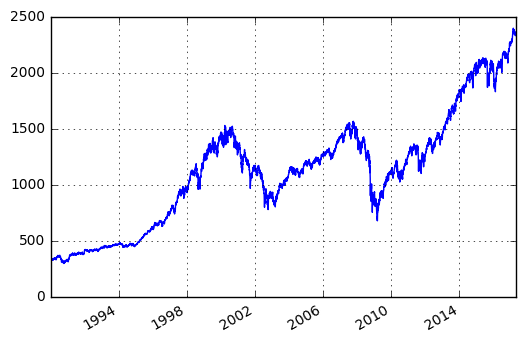

In [88]:

if ticker =='^GSPC':
    price_variable = 'close_price'
    df=dfsp
    df[price_variable].plot(grid=True)  


else:
    price_variable ='adj_close_price'
    df=dfs
    df[price_variable].plot(grid=True)   
    df[['pricetoearnings']].plot(grid=True)
    df[['ebitdagrowth','earningsyield','quickratio']].plot(grid=True)
    
    
print('ticker =',ticker)

In [101]:
# Nday Trend (tnp1)
#   N Plus 1 .... predict today for N plus 1 (tomorrow)

    #tnp1=pd.DataFrame(np.sign(dfsp['close_price']).shift(-1))
    #tnp1=tnp1.rename(columns={'close_price':'t_np1'})
%run algosciquant
ndtrend = 40
dx=0.01
print('ndtrend = ',ndtrend)
print('dx =',dx)

if ticker =='^GSPC':
    price_variable = 'close_price'
    df=dfsp
else:
    price_variable ='adj_close_price'
    df=dfs
    
print('ticker = ',ticker)
print('price_variable = ',price_variable)       


dftruth,dfnday=ndTrendFill(df,price_variable,ndtrend,dx)

ndays_dt = dt.timedelta(days=ndtrend)

plus_ndays = dfnday.index[len(dfnday.index)-2] + ndays_dt
pndays_str=str(plus_ndays.year)+'-'+str(plus_ndays.month)+'-'+str(plus_ndays.day)
print('plus_ndays =',pndays_str)

print(dftruth.columns)
print('...')
dftruth['t_np1'] = dftruth['t'].shift(-1)
del dftruth['t']
print("\ndftruth columns")
print(dftruth.columns)
print(dftruth.tail(5))
print(dfnday.tail(5))


ndtrend =  40
dx = 0.01
ticker =  ^GSPC
price_variable =  close_price
plus_ndays = 2017-5-13
Index(['t'], dtype='object')
...

dftruth columns
Index(['t_np1'], dtype='object')
            t_np1
2017-04-17   -1.0
2017-04-18   -1.0
2017-04-19   -1.0
2017-04-20   -1.0
2017-04-21    NaN
           close_price
2016-11-28     2201.72
2017-01-09      2268.9
2017-02-21     2365.38
2017-04-03     2358.84
2017-04-21     2348.69


In [1115]:
# Ndtrend - save 

if ticker =='^GSPC':
    tick = 'sp'
    price_variable='close_price'
else:
    tick = ticker
    price_variable='adj_close_price'
ndt_save_filename=tick+'_ndt'+str(ndtrend)+'_'+str(test_st.year)+'_20170412.csv'
print('filename = ',ndt_save_filename)
dftruth.to_csv(ndt_save_filename)

filename =  AAPL_ndt45_2014_20170412.csv


In [770]:
# Read - Ndtrend Truth read filename
ndtrend=45
tick='AAPL'
ndt_read_filename=tick+'_ndt'+str(ndtrend)+'_'+str(test_st.year)+'_20170412.csv'
print('filename = ',ndt_read_filename)
dftruth = pd.read_csv(ndt_read_filename,index_col=0,parse_dates=True)

filename =  AAPL_ndt45_2014_20170412.csv


Index(['close_price', 'high_price', 'low_price', 'open_price', 'volume'], dtype='object')

In [102]:
# ML Feature Data Frame

%run algosciquant
print(ticker)
f2p=[2,5,10,20,30,60,90,120]
if ticker == '^GSPC' or ticker == 'SPX':
    mlFeatures=['sp_close_price','sp_close_pricer','sp_volume','sp_volumer']
    #mlFeatures=['sp_close_pricer','sp_volumer','sp_close_price']
    #mlFeatures=['sp_close_pricer','sp_volumer']
    print('\nmlFeatures')
    print(mlFeatures)
    print('\ndfsp.columns')
    print(dfsp.columns)
    dfML=mlHistoryFeatures(dfsp,dfsp,mlFeatures,f2p)
    # S&P High and Low Relative to Open
    
    dfML['high_price_ropen']=dfsp['high_price']/dfsp['open_price']-1
    dfML['low_price_ropen']=dfsp['low_price']/dfsp['open_price']-1
    
else:   
    mlFeatures=['adj_close_price', 'adj_close_pricer', 'pricetoearnings','ebitdagrowth','quickratio','earningsyield' ,'sp_close_pricer','sp_close_price','sp_volume']
    #mlFeatures=['adj_close_pricer', 'pricetobook', 'sp_close_pricer','sp_volume']

    print('\nmlFeatures')
    print(mlFeatures)
    print('\ndfs.columns')
    print(dfs.columns)
    dfML=mlHistoryFeatures(dfs,dfsp,mlFeatures,f2p)
    #dfML['sp_volume']=dfsp['volume']
    #''adj_volume
    mlFeatures2=['adj_close_price','adj_volume']
    print('\nmlFeatures2')
    dfML[mlFeatures2]=dfs[mlFeatures2]


print("\nML features")
print(dfML.columns)

print('\nML Features (tail(3))')
print(dfML.tail(3))



^GSPC

mlFeatures
['sp_close_price', 'sp_close_pricer', 'sp_volume', 'sp_volumer']

dfsp.columns
Index(['close_price', 'high_price', 'low_price', 'open_price', 'volume'], dtype='object')

ML features
Index(['sp_close_pricer', 'sp_close_price', 'sp_volumer', 'sp_volume',
       'sp_close_price_h1', 'sp_close_price_h2', 'sp_close_price_ma5',
       'sp_close_price_ma10', 'sp_close_price_ma20', 'sp_close_price_ma30',
       'sp_close_price_ma60', 'sp_close_price_ma90', 'sp_close_price_ma120',
       'sp_close_pricer_h1', 'sp_close_pricer_h2', 'sp_close_pricer_ma5',
       'sp_close_pricer_ma10', 'sp_close_pricer_ma20', 'sp_close_pricer_ma30',
       'sp_close_pricer_ma60', 'sp_close_pricer_ma90', 'sp_close_pricer_ma120',
       'sp_volume_h1', 'sp_volume_h2', 'sp_volume_ma5', 'sp_volume_ma10',
       'sp_volume_ma20', 'sp_volume_ma30', 'sp_volume_ma60', 'sp_volume_ma90',
       'sp_volume_ma120', 'sp_volumer_h1', 'sp_volumer_h2', 'sp_volumer_ma5',
       'sp_volumer_ma10', 'sp_volumer_ma2

In [103]:
#  Classifier Model Training and Prediction
#   for each test date a classifier will be trained until test date - 1

%run algosciquant 

# Create training data frames ... separate into X and Y
X = dfML.loc[train_st:test_et,dfML.columns]
Y = dftruth.loc[train_st:test_et]

print("X columns")
print(X.columns)

print('Y columns')
print(Y.columns)

mc=0
dftflag=pd.DataFrame()

##### Decision Treee
ntraindays = 300
v=1
model='DT'
clf = DecisionTreeClassifier(min_samples_split=20, random_state=99)

##### Random Forest
#ne=366
#v=2
#ntraindays = 1000
#model="RF"
#clf = RandomForestClassifier(n_estimators=ne, random_state=2)

##### K Nearest Neighbor
#k=5
#model="KNN"
#clf=KNeighborsClassifier(n_neighbors=k,algorithm='auto')

#### XG Boost
#ntraindays = 1000
#v=2
#model="XGB"
#clf = XGBClassifier()

##### Support Vector Machine
#ntraindays = 500
#v=1
#model='SVM'
#clf = svm.SVC(kernel='rbf', C=1,gamma='auto')

##### Gausian Naive-Bayes
#ntraindays = 2000
#v=1
#model = "GNB"
#clf = GaussianNB()

##### Logistic Regression
#ntraindays = 300
#v=1
#model = "LR"
#clf = LogisticRegression()

##### Run the classifier 
print('ticker =',ticker)
print('ndtrend = ',ndtrend)
print('dx =',dx)
print('test start date =',test_st)
print('ntraindays = ',ntraindays)
print('model = ',model)
dfTR,clf = mClfTrainTest(X,Y,train_st,test_st,test_et,clf,ntraindays,mc=mc,dftflag=dftflag,v=v)


dfTR[['train_st','train_et','t', 'p','tf','t_np1','p_np1']].tail(10)

X columns
Index(['sp_close_pricer', 'sp_close_price', 'sp_volumer', 'sp_volume',
       'sp_close_price_h1', 'sp_close_price_h2', 'sp_close_price_ma5',
       'sp_close_price_ma10', 'sp_close_price_ma20', 'sp_close_price_ma30',
       'sp_close_price_ma60', 'sp_close_price_ma90', 'sp_close_price_ma120',
       'sp_close_pricer_h1', 'sp_close_pricer_h2', 'sp_close_pricer_ma5',
       'sp_close_pricer_ma10', 'sp_close_pricer_ma20', 'sp_close_pricer_ma30',
       'sp_close_pricer_ma60', 'sp_close_pricer_ma90', 'sp_close_pricer_ma120',
       'sp_volume_h1', 'sp_volume_h2', 'sp_volume_ma5', 'sp_volume_ma10',
       'sp_volume_ma20', 'sp_volume_ma30', 'sp_volume_ma60', 'sp_volume_ma90',
       'sp_volume_ma120', 'sp_volumer_h1', 'sp_volumer_h2', 'sp_volumer_ma5',
       'sp_volumer_ma10', 'sp_volumer_ma20', 'sp_volumer_ma30',
       'sp_volumer_ma60', 'sp_volumer_ma90', 'sp_volumer_ma120',
       'high_price_ropen', 'low_price_ropen'],
      dtype='object')
Y columns
Index(['t_np1'], dtype=

,train_st,train_et,t,p,tf,t_np1,p_np1
2017-03-30,2016-06-03,2017-03-28,-1.0,-1.0,1,-1.0,-1.0
2017-03-31,2016-06-04,2017-03-29,-1.0,-1.0,1,-1.0,-1.0
2017-04-03,2016-06-07,2017-03-30,-1.0,-1.0,1,-1.0,-1.0
2017-04-04,2016-06-08,2017-03-31,-1.0,-1.0,1,-1.0,-1.0
2017-04-05,2016-06-09,2017-04-03,-1.0,-1.0,1,-1.0,-1.0
2017-04-06,2016-06-10,2017-04-04,-1.0,-1.0,1,-1.0,-1.0
2017-04-07,2016-06-11,2017-04-05,-1.0,-1.0,1,-1.0,-1.0
2017-04-10,2016-06-14,2017-04-06,-1.0,-1.0,1,-1.0,-1.0
2017-04-11,2016-06-15,2017-04-07,-1.0,-1.0,1,-1.0,-1.0
2017-04-12,2016-06-16,2017-04-10,-1.0,-1.0,1,-1.0,-1.0


In [104]:
# Smooth Predictions
%run algosciquant 

if ticker == '^GSPC':
    price_variable2='close_price'
else:
    price_variable2=price_variable

startindex = dfnday.index[dfnday.index.searchsorted(test_st)]
print('startindex =',startindex)
dfps = ndTrendSmooth(dfTR,startindex,'p',ndtrend)
add_dftr_cols=['train_st','train_et','t','p','t_np1','p_np1']
dfps[add_dftr_cols]=dfTR[add_dftr_cols]
if ticker == '^GSPC':
    dfps[price_variable]=dfsp[price_variable]
else:
    dfps[price_variable]=dfs[price_variable]
print('ticker =',ticker)
print('price_variable =',price_variable)
dfps[[price_variable2,'train_st','train_et','t', 'p','t_np1','p_np1']].tail(5)

startindex = 2000-01-03 00:00:00
ticker = ^GSPC
price_variable = close_price


,close_price,train_st,train_et,t,p,t_np1,p_np1
2017-04-06,2357.489990,2016-06-10,2017-04-04,-1.0,-1.0,-1.0,-1.0
2017-04-07,2355.540039,2016-06-11,2017-04-05,-1.0,-1.0,-1.0,-1.0
2017-04-10,2357.159912,2016-06-14,2017-04-06,-1.0,-1.0,-1.0,-1.0
2017-04-11,2353.780029,2016-06-15,2017-04-07,-1.0,-1.0,-1.0,-1.0
2017-04-12,2344.929932,2016-06-16,2017-04-10,-1.0,-1.0,-1.0,-1.0


In [78]:
# save dfTR and dfps Training Results DataFrame File 
if ticker == '^GSPC':
    tick='sp'
else:
    tick=ticker

str_test_et=str(test_et.year)+str(test_et.month)+str(test_et.day)
str_test_styr=str(test_st.year)

save_dtr_filename='dfclfm_'+tick+'_ndt'+str(ndtrend)+'_'+str_test_styr+'_'+str_test_et+'_'+model+'.csv'
save_dfps_filename='dfps_'+tick+'_ndt'+str(ndtrend)+'_'+str_test_styr+'_'+str_test_et+'_'+model+'.csv'

print('filename =',save_dtr_filename)
print('filename =',save_dfps_filename)
dfTR.to_csv(save_dtr_filename)
dfps.to_csv(save_dfps_filename)

filename = dfclfm_AAPL_ndt1_2014_2017421_DT.csv
filename = dfps_AAPL_ndt1_2014_2017421_DT.csv


In [1046]:
# read dfTR Training Results DataFrame File 
model='DT'
ticker='AAPL'
ndtrend=45
ftest_st=dt.datetime(2014,1,1)
ftest_et=dt.datetime(2017,4,12)

if ticker == '^GSPC':
    tick='sp'
else:
    tick=ticker

str_test_et=str(ftest_et.year)+str(ftest_et.month)+str(ftest_et.day)
str_test_styr=str(ftest_st.year)

read_dtr_filename='dfclfm_'+tick+'_ndt'+str(ndtrend)+'_'+str_test_styr+'_'+str(ftest_et.year)+str(ftest_et.month)+str(ftest_et.day)+'_'+model+'.csv'
read_dfps_filename='dfps_'+tick+'_ndt'+str(ndtrend)+'_'+str_test_styr+'_'+str(ftest_et.year)+str(ftest_et.month)+str(ftest_et.day)+'_'+model+'.csv'

print('filename =',read_dtr_filename)
print('filename =',read_dfps_filename)
dfTR = pd.read_csv(read_dtr_filename,index_col=0,parse_dates=True)
dfps = pd.read_csv(read_dfps_filename,index_col=0,parse_dates=True)

filename = dfclfm_AAPL_ndt45_2014_2017412_DT.csv
filename = dfps_AAPL_ndt45_2014_2017412_DT.csv


In [105]:
%run algosciquant
clfMktConfusionMatrix(dfTR,"t",'p')

(4347,
 674,
 3673,
 0.15504945939728548,
 330,
 342,
 1697,
 1976,
 0.16272189349112426,
 0.14754098360655737,
 0.8367850098619329,
 0.8524590163934426,
               Actual Totals Predicted MktDwn Predicted MktUp
 actual MktDwn    pos:MktDwn               tp              fn
 actual MktUp      neg:MktUp               fp              tn,
                Actual Totals  Predicted MktDwn  Predicted MktUp
 actual MktDwn           2028              1697              330
 actual MktUp            2318               342             1976,
                Actual Totals  Predicted MktDwn  Predicted MktUp
 actual MktDwn           2028          0.836785         0.162722
 actual MktUp            2318          0.147541         0.852459)

In [68]:
%run algosciquant
clfMktConfusionMatrix(dfps,"t",'ps')

total = 844 
  pos (up) =  837 
  neg (dwn) 6
errors = 32 correct =  812


(844,
 32,
 812,
 0.037914691943127965,
 25,
 7,
 812,
 0,
 0.02986857825567503,
 1.1666666666666667,
 0.970131421744325,
 0.0,
               Actual Totals Predicted MktDwn Predicted MktUp
 actual MktDwn    pos:MktDwn               tp              fn
 actual MktUp      neg:MktUp               fp              tn,
                Actual Totals  Predicted MktDwn  Predicted MktUp
 actual MktDwn            837               812               25
 actual MktUp               6                 7                0,
                Actual Totals  Predicted MktDwn  Predicted MktUp
 actual MktDwn            837          0.970131         0.029869
 actual MktUp               6          1.166667         0.000000)

In [32]:
dfsp.tail(5)

,close_price,high_price,low_price,open_price,volume
2017-03-30,2368.060059,2370.419922,2358.580078,2361.310059,3158420000
2017-03-31,2362.719971,2370.350098,2362.600098,2364.820068,3354110000
2017-04-03,2358.840088,2365.870117,2344.729980,2362.340088,3416400000
2017-04-04,2360.159912,2360.530029,2350.719971,2354.760010,3206240000
2017-04-05,2354.230000,2378.360000,2350.520000,2366.590000,3206240000


In [232]:
# Learning Summary Results

# Date 2017-04-14
# S&P 2014-01-01 to 2017-04-12
# S&P close_price 2014-01-12, 2344.93


# S&P500 2014-01-01 to 2017-04-05
# DT, ndraindays = 300 ... decreasing accuracy in incrasing ndtraining days
# ndtrend = 45
#  mlFeatures 
#       sp_close_price, f2p=[2,5,10,20,30,60,90,120] -->   14.2509 % error
#       sp_close_price, f2p=[5,5,10,20,30,60,90,120] -->   12.667 % error
#       sp_close_price, f2p=[6,5,10,20,30,60,90,120] -->   12.7 % error
#      + sp_close_pricer, f2p=[5,5,10,20,30,60,90,120] --> 12.4% error 
#      + relative intra-day high and low to open --> 13.03%
#      + sp_volume --> 13.5%
#      + sp_volumer --> 13.5%

# RF, ndtraining = 1000 ... did not see improvement in increasing ndtraining days
#  ndtrend=45
#      sp_close_price, f2p=[5,5,10,20,30,60,90,120] -->   13.64% error
#      +sp_close_pricer f2p=[5,5,10,20,30,60,90,120] ---> 15.9 % error
#      +sp_volume  --> 12.5% error
#      +sp_volumer  --> 10.109% error
#      + intra-day relative intra-day high/low to open  --> 10.5968 %error
#    **f2p=[2,5,10,20,30,60,90,120]   ---> 9.6224 %
#      f2p=[3,5,10,20,30,60,90,120]   ---> 9.98782 %
#      sp_close_price, sp_close_pricer, f2p=[2,5,10,20,30,60,90,120] -->   14.9% error

    sp_rf_error  sp_rf_price_sp  sp_dt_error  sp_dt_price_sp  AAPL_dt_error  \
1        0.1160         1828.54      0.19600         1876.33         0.4093   
2        0.1876         2056.84      0.25790         1876.66         0.4439   
3        0.2591         2083.33      0.35400         2386.42         0.4642   
5        0.3002         2546.66      0.37700         2128.16         0.4165   
10       0.2894         2835.65      0.33170         2672.52         0.3544   
20       0.1937         2943.31      0.21600         2652.51         0.2021   
30       0.1695         2764.85      0.21000         2647.47         0.1742   
40       0.0969         3066.15      0.12100         3021.46         0.1110   
45       0.0956         2683.86      0.14400         2797.20         0.1038   
50       0.1114         2587.90      0.14116         2544.21         0.1158   

    AAPL_dt_sp  AAPL_rf_error  AAPL_rf_sp  MCD_dt_error  MCD_dt_st  \
1        85.43         0.2768       83.75        0.2733    1

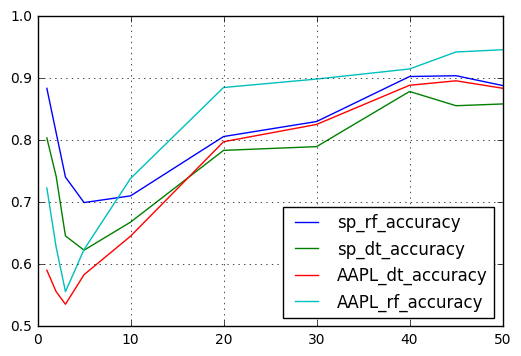

In [1155]:
# Training Results Summary
# Date 2017-04-14

index=[1,2,3,5,10,20,30, 40,45, 50]
columns=['sp_rf_error',
                'sp_rf_price_sp',
                         'sp_dt_error', 
                                 'sp_dt_price_sp',
                                          'AAPL_dt_error',
                                                'AAPL_dt_sp',
                                                        'AAPL_rf_error' ,
                                                               'AAPL_rf_sp' ,
                                                                    'MCD_dt_error',
                                                                              'MCD_dt_sp']
results=[(0.116, 1828.54, 0.196, 1876.33,0.4093,85.43, 0.2768,83.75 ,0.2733,116.87),  # 1
         (0.1876,2056.84, 0.2579,1876.66,0.4439,82.9,  0.3723,85.97 ,0.324, 111.95),  # 2
         (0.2591,2083.33, 0.354, 2386.42,0.4642,171.1, 0.4439,143.81,0.335, 117.44),  # 3
         (0.3002,2546.660,0.377, 2128.16,0.4165,114.02,0.3759,196.71,0.4268,141.93),  # 5
         (0.2894,2835.65, 0.3317,2672.52,0.3544,234.13,0.2613,318.64,0.3047,141.34),  # 10
         (0.1937,2943.31, 0.216, 2652.51,0.2021,255.6, 0.1146,243.93,0.2189,165.65),  # 20
         (0.1695,2764.850,0.21,  2647.47,0.1742,237.9, 0.101 , 247.45,0.1342,146.08), # 30  
         (0.0969,3066.15, 0.121, 3021.46,0.111, 245.02,0.0847, 226.48,0.0955,200.255),# 40
         (0.0956,2683.86, 0.144 ,2797.20,0.1038,261.3, 0.0573, 268.31,0.1294,137.19), # 45
         (0.1114,2587.9,0.14116,2544.21, 0.1158,218.91,0.0537, 231.42,0.1027,175.55)] # 50

#print(dftrainresults[['sp_rf_error','sp_dt_error','AAPL_dt_error']])

# S&P close_price 2014-01-12, $2344.93
#   index = ndtrend days
#   S&P 2014-01-01 to 2017-04-12
#   features - sp_close_price, sp_close_pricr, volume, volumer, 
#
# AAPL 
#  # 2014-01-01 to 2017-04-1
#  start price 72.124, end price 141.79
#  f2p=[2,5,10,20,30,60,90,120]
#
# MCD
#  # 2014-01-01 to 2017-04-1
#  start price 86.67, end price 131.21
#  f2p=[2,5,10,20,30,60,90,120]
#   DT 55, 9.55, 153.96

 
dftrainresults=pd.DataFrame(results,columns=columns,index=index)
dftrainresults['sp_rf_accuracy']=1-dftrainresults['sp_rf_error']
dftrainresults['sp_dt_accuracy']=1-dftrainresults['sp_dt_error']
dftrainresults['AAPL_dt_accuracy']=1-dftrainresults['AAPL_dt_error']
dftrainresults['AAPL_rf_accuracy']=1-dftrainresults['AAPL_rf_error']
dftrainresults[['sp_rf_accuracy','sp_dt_accuracy','AAPL_dt_accuracy','AAPL_rf_accuracy']].plot(use_index=True,grid=True)
plt.xlim(0,50)
plt.ylim(0.5,1)
#print(dftrainresults[['sp_rf_accuracy','sp_dt_accuracy','APPL_dt_accuracy']])
print(dftrainresults)

In [213]:
# Read - Ndtrend Truth read filename

ftp_40='sp_ndt40_'+'1950_20170412.csv'
ftp_30='sp_ndt30_'+'1950_20170412.csv'
df1 = pd.read_csv(ftp_40,index_col=0,parse_dates=True)
df2 = pd.read_csv(ftp_30,index_col=0,parse_dates=True)

df1=df1.rename(columns={'t_np1':'tnp1_40'})
df2=df2.rename(columns={'t_np1':'tnp1_30'})

dftp=pd.concat([df1,df2],axis=1)
dftp.head(5)

,tnp1_40,tnp1_30
1990-01-02,-1.0,-1.0
1990-01-03,-1.0,-1.0
1990-01-04,-1.0,-1.0
1990-01-05,-1.0,-1.0
1990-01-08,-1.0,-1.0


Index(['ps', 'train_st', 'train_et', 't', 'p', 't_np1', 'p_np1',
       'close_price'],
      dtype='object')
ticker = ^GSPC


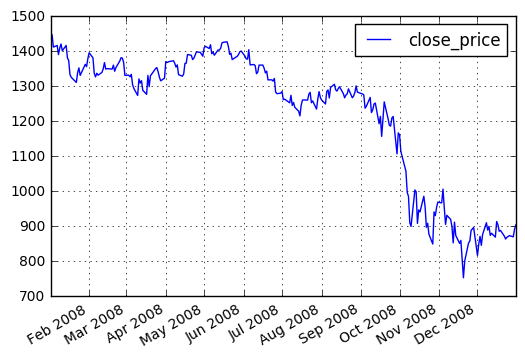

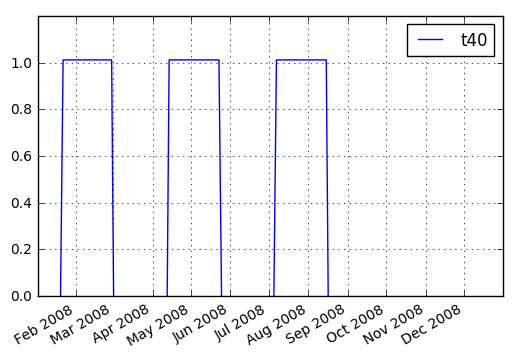

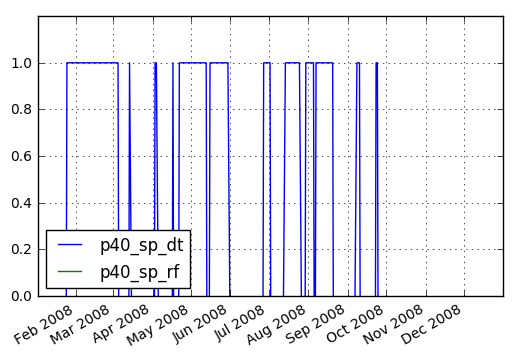

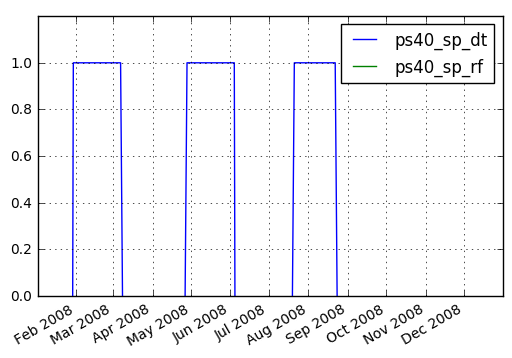

In [99]:
# Graph T,P,PS files

tick='^GSPC'


if tick == '^GSPC':
    st=dt.datetime(2008,1,1)
    et=dt.datetime(2008,12,31)
    price_variable='close_price'
    fps_dt_45 = 'dfps_sp_ndt45_2000_2017412_DT.csv'
    fps_dt_40 = 'dfps_sp_ndt40_2000_2017412_DT.csv'
    fps_rf_40 = 'dfps_sp_ndt40_2000_2017412_RF.csv'
    fps_dt_30 = 'dfps_sp_ndt30_2000_2017412_DT.csv'
    fps_dt_20 = 'dfps_sp_ndt20_2000_2017412_DT.csv'
    fps_dt_10 = 'dfps_sp_ndt10_2000_2017412_DT.csv'


if tick =='AAPL':
    st=dt.datetime(2014,1,1)
    et=dt.datetime(2015,12,31)
    #st=dt.datetime(2014,12,1)
    #et=dt.datetime(2015,6,1)
    #st=dt.datetime(2015,3,22)
    #et=dt.datetime(2015,4,12)
    price_variable='adj_close_price'
    fps_dt_45 = 'dfps_AAPL_ndt45_2014_2017412_DT.csv'
    fps_rf_45 = 'dfps_AAPL_ndt45_2014_2017412_RF.csv'
    fps_dt_40 = 'dfps_AAPL_ndt40_2014_2017412_DT.csv'
    fps_rf_40 = 'dfps_AAPL_ndt40_2014_2017412_RF.csv'
    fps_dt_30 = 'dfps_AAPL_ndt30_2014_2017412_DT.csv'
    fps_rf_30 = 'dfps_AAPL_ndt30_2014_2017412_RF.csv'
    fps_dt_20 = 'dfps_AAPL_ndt20_2014_2017412_DT.csv'
    fps_dt_10 = 'dfps_AAPL_ndt10_2014_2017412_DT.csv'
    dfps_rf_45 = pd.read_csv(fps_rf_45,index_col=0,parse_dates=True)

dfps_dt_45 = pd.read_csv(fps_dt_45,index_col=0,parse_dates=True)
dfps_dt_40 = pd.read_csv(fps_dt_40,index_col=0,parse_dates=True)
dfps_rf_40 = pd.read_csv(fps_rf_40,index_col=0,parse_dates=True)
dfps_dt_30 = pd.read_csv(fps_dt_30,index_col=0,parse_dates=True)
dfps_dt_20 = pd.read_csv(fps_dt_20,index_col=0,parse_dates=True)
dfps_dt_10 = pd.read_csv(fps_dt_10,index_col=0,parse_dates=True)

print(dfps_dt_40.columns)
dftp=dfps_dt_40[[price_variable,'t','p','ps']].copy()
dftp.rename(columns={'t':'t40','p':'p40_dt','ps':'ps40_dt'},inplace=True)

dftp[['t45','p45_dt','ps45_dt']]=dfps_dt_45[['t','p','ps']]
dftp[['p40_dt','ps40_dt']]=dfps_dt_40[['p','ps']]
dftp[['p45_rf','ps45_rf']]=dfps_rf_45[['p','ps']]
dftp[['t30','p30_dt','ps30_dt']]=dfps_dt_30[['t','p','ps']]
dftp[['t20','p20_dt','ps20_dt']]=dfps_dt_20[['t','p','ps']]
dftp[['t10','p10_dt','ps10_dt']]=dfps_dt_10[[ 't','p','ps']]

dftp.loc[st:et,[price_variable]].plot(grid=True)

dftmp=dftp.loc[st:et,['t45']]
dftmp['t40']=dftp.loc[st:et,['t40']]+0.0125
dftmp['t30']=dftp.loc[st:et,['t30']]+0.025
dftmp['t20']=dftp.loc[st:et,['t20']]+0.0375
dftmp['t10']=dftp.loc[st:et,['t10']]+0.05


print('ticker =',tick)
if tick=='^GSPC':
    dftmp['p40_sp_dt']=dftp.loc[st:et,['p40_dt']]
    dftmp['ps40_sp_dt']=dftp.loc[st:et,['ps40_dt']]
    dftmp['t40']=dftp.loc[st:et,['t40']]+0.0125
    dftmp['t30']=dftp.loc[st:et,['t30']]+0.025
    dftmp['t20']=dftp.loc[st:et,['t20']]+0.0375
    dftmp['t10']=dftp.loc[st:et,['t10']]+0.05

    dftmp.loc[st:et,['t40']].plot(grid=True)

    plt.ylim(0,1.2)
    dftmp.loc[st:et,['p40_sp_dt','p40_sp_rf']].plot(grid=True)
    plt.ylim(0,1.2)
    dftmp.loc[st:et,['ps40_sp_dt','ps40_sp_rf']].plot(grid=True)
    plt.ylim(0,1.2)
    
else:
    
    dftmp['p45_AAPL_dt']=dftp.loc[st:et,['p45_dt']]
    dftmp['ps45_AAPL_dt']=dftp.loc[st:et,['ps45_dt']]
    dftmp['ps45_AAPL_rf']=dftp.loc[st:et,['ps45_rf']]
    dftmp['p45_AAPL_rf']=dftp.loc[st:et,['p45_rf']]
    dftmp['p40_AAPL_dt']=dftp.loc[st:et,['p40_dt']]
    dftmp['p30_AAPL_dt']=dftp.loc[st:et,['p30_dt']]
    dftmp['p20_AAPL_dt']=dftp.loc[st:et,['p20_dt']]
    dftmp['p10_AAPL_dt']=dftp.loc[st:et,['p10_dt']]
    
    dftmp.loc[st:et,['t45']].plot(grid=True)
    plt.ylim(0,1.2)
    dftmp.loc[st:et,['p45_AAPL_dt','p45_AAPL_rf']].plot(grid=True)
    plt.ylim(0,1.2)
    dftmp.loc[st:et,['ps45_AAPL_dt','ps45_AAPL_rf']].plot(grid=True)
    plt.ylim(0,1.2)




#dftmp.loc[st:et,['t45','t40','t30','t20','t10']].plot(grid=True)
#plt.ylim(0,1.2)


In [110]:
# read dfTR Training Results DataFrame File 
model='RF'
ticker='^GSPC'
ndtrend=40

ftest_st=dt.datetime(2000,1,1)
ftest_et=dt.datetime(2017,4,12)

if ticker == '^GSPC':
    tick='sp'
else:
    tick=ticker

str_test_et=str(ftest_et.year)+str(ftest_et.month)+str(ftest_et.day)
str_test_styr=str(ftest_st.year)

read_dtr_filename='dfclfm_'+tick+'_ndt'+str(ndtrend)+'_'+str_test_styr+'_'+str(ftest_et.year)+str(ftest_et.month)+str(ftest_et.day)+'_'+model+'.csv'
read_dfps_filename='dfps_'+tick+'_ndt'+str(ndtrend)+'_'+str_test_styr+'_'+str(ftest_et.year)+str(ftest_et.month)+str(ftest_et.day)+'_'+model+'.csv'

print('filename =',read_dtr_filename)
print('filename =',read_dfps_filename)
dfTR = pd.read_csv(read_dtr_filename,index_col=0,parse_dates=True)
dfps = pd.read_csv(read_dfps_filename,index_col=0,parse_dates=True)

#dfclfm_sp_ndt40_2000_2017412_RF.csv

filename = dfclfm_sp_ndt40_2000_2017412_RF.csv
filename = dfps_sp_ndt40_2000_2017412_RF.csv


In [76]:
print(model)

RF


In [111]:
# Strategy Trade CLF
%run algosciquant

pvariable='p'   #, p, ps, mcupm

start_strategy_trade=dfps.index[0]


#start_strategy_trade=test_st
startyr=start_strategy_trade.year
today = dt.date.today()
end_strategy_trade=dt.datetime(today.year,today.month,today.day)
endyr=today.year
startyr=start_strategy_trade.year
yday = datetime.today().timetuple().tm_yday


print('start strategy trade date =',start_strategy_trade)
print('end date =',test_et)

print(ticker)
if ticker == '^GSPC' or ticker == 'SPX':
    price_variable='close_price'  # Price Intrinio
else:
    
    price_variable='adj_close_price'

print(price_variable) 
print('model =',model)
print('ndtrend =',ndtrend)

df1=dfps.loc[start_strategy_trade:end_strategy_trade,[price_variable+'r','t','p','ps','t_np1','p_np1']]

if price_variable in dfsp.columns:
    df2=dfsp.loc[start_strategy_trade:end_strategy_trade,[price_variable]] 
elif price_variable in dfs.columns:
    df2=dfs.loc[start_strategy_trade:end_strategy_trade,[price_variable]] 

dft=pd.concat([df1, df2], axis=1,join='inner')
dft = tradeReturns(dft,price_variable)

dft = strategyTrade(dft,price_variable,price_variable+'_R',pvariable)

if price_variable in dfsp.columns:
    dft.loc[dft.index[0],price_variable+'_SP']=dft.loc[dft.index[0],price_variable]
    print(dft[[price_variable,price_variable+'_R',price_variable+'_SP','t',pvariable,'t_np1','p_np1']].head(5))

    print(dft[[price_variable,price_variable+'_R',price_variable+'_SP','t',pvariable,'t_np1','p_np1']].tail(5))
elif price_variable in dfs.columns:
    dft.loc[dft.index[0],price_variable+'_SP']=dft.loc[dft.index[0],price_variable]
    print(dft[[price_variable,price_variable+'_R',price_variable+'_SP','t',pvariable,'t_np1','p_np1']].head(5))
    print(dft[[price_variable,price_variable+'_R',price_variable+'_SP','t',pvariable,'t_np1','p_np1']].tail(5))

start strategy trade date = 2000-01-03 00:00:00
end date = 2017-04-12 00:00:00
^GSPC
close_price
model = RF
ndtrend = 40
            close_price  close_price_R  close_price_SP    t    p  t_np1  p_np1
2000-01-03  1455.219971       0.000000     1455.219971  NaN  NaN   -1.0    0.0
2000-01-04  1399.420044      -0.038345     1455.219971 -1.0  0.0   -1.0    1.0
2000-01-05  1402.109985       0.001922     1458.017170 -1.0  1.0   -1.0    1.0
2000-01-06  1403.449951       0.000956     1459.410565 -1.0  1.0   -1.0    1.0
2000-01-07  1441.469971       0.027090     1498.946580 -1.0  1.0   -1.0    1.0
            close_price  close_price_R  close_price_SP    t    p  t_np1  p_np1
2017-04-06  2357.489990       0.001930    28510.463291 -1.0 -1.0   -1.0   -1.0
2017-04-07  2355.540039      -0.000827    28510.463291 -1.0 -1.0   -1.0   -1.0
2017-04-10  2357.159912       0.000688    28510.463291 -1.0 -1.0   -1.0   -1.0
2017-04-11  2353.780029      -0.001434    28510.463291 -1.0 -1.0   -1.0   -1.0
2017-04-12

In [112]:
# BackTest Summary
%run algosciquant

print(price_variable) 
print('model =',model)
print('ndtrend =',ndtrend)
(dftsummary,dfreturns)=backTest(dft,price_variable,start_strategy_trade,end_strategy_trade)

print(dftsummary)
print("")
print(dfreturns[[ 'nyear',  'Rc','Ra','Rc_strat','Ra_strat']])

close_price
model = RF
ndtrend = 40
     start_date  start_close_price   end_date  end_close_price  \
2000 2000-01-03        1455.219971 2001-01-02      1283.270020   
2001 2001-01-02        1283.270020 2001-12-31      1148.079956   
2002 2002-01-02        1154.670044 2002-12-31       879.820007   
2003 2003-01-02         909.030029 2003-12-31      1111.920044   
2004 2004-01-02        1108.479980 2004-12-31      1211.920044   
2005 2005-01-03        1202.079956 2006-01-03      1268.800049   
2006 2006-01-03        1268.800049 2007-01-03      1416.599976   
2007 2007-01-03        1416.599976 2007-12-31      1468.359985   
2008 2008-01-02        1447.160034 2008-12-31       903.250000   
2009 2009-01-02         931.799988 2009-12-31      1115.099976   
2010 2010-01-04        1132.989990 2010-12-31      1257.640015   
2011 2011-01-03        1271.869995 2012-01-03      1277.060059   
2012 2012-01-03        1277.060059 2012-12-31      1426.189941   
2013 2013-01-02        1462.420044 2013-

In [938]:
#Save Trade Summaries

if ticker == '^GSPC':
    tick='sp'
else:
    tick=ticker


str_test_styr=str(start_strategy_trade.year)
str_test_et=str(test_et.year)+str(test_et.month)+str(test_et.day)

save_dft_filename='dft_'+tick+'_ndt'+str(ndtrend)+'_'+str_test_styr+'_'+str_test_et+'_'+model+'.csv'
save_dfts_filename='dfts_'+tick+'_ndt'+str(ndtrend)+'_'+str_test_styr+'_'+str_test_et+'_'+model+'.csv'
save_dftrs_filename='dftrs_'+tick+'_ndt'+str(ndtrend)+'_'+str_test_styr+'_'+str_test_et+'_'+model+'.csv'

print('dft filename =',save_dft_filename)
print('dfts filename =',save_dfts_filename)
print('dftrs filename =',save_dftrs_filename)
dft.to_csv(save_dft_filename)
dftsummary.to_csv(save_dfts_filename)
dfreturns.to_csv(save_dftrs_filename)

#save_dft_filename=dft_

dft filename = dft_AAPL_ndt45_2008_2017412_DT.csv
dfts filename = dfts_AAPL_ndt45_2008_2017412_DT.csv
dftrs filename = dftrs_AAPL_ndt45_2008_2017412_DT.csv


In [939]:
# read trade summary files
model='DT'
ticker='AAPL'
ndtrend=45

ftest_st=dt.datetime(2008,1,1)
ftest_et=dt.datetime(2017,4,12)

if ticker == '^GSPC':
    tick='sp'
else:
    tick=ticker

str_test_et=str(ftest_et.year)+str(ftest_et.month)+str(ftest_et.day)
str_test_styr=str(ftest_st.year)

read_dft_filename='dft_'+tick+'_ndt'+str(ndtrend)+'_'+str_test_styr+'_'+str(ftest_et.year)+str(ftest_et.month)+str(ftest_et.day)+'_'+model+'.csv'
read_dfts_filename='dfts_'+tick+'_ndt'+str(ndtrend)+'_'+str_test_styr+'_'+str_test_et+'_'+model+'.csv'
read_dftrs_filename='dftrs_'+tick+'_ndt'+str(ndtrend)+'_'+str_test_styr+'_'+str_test_et+'_'+model+'.csv'


print('filename =',read_dft_filename)
print('dfts filename =',read_dfts_filename)
print('dftrs filename =',read_dftrs_filename)

dft = pd.read_csv(read_dft_filename,index_col=0,parse_dates=True)
dftsummary = pd.read_csv(read_dfts_filename,index_col=0,parse_dates=True)
dfreturns = pd.read_csv(read_dftrs_filename,index_col=0,parse_dates=True)

filename = dft_AAPL_ndt45_2008_2017412_DT.csv
dfts filename = dfts_AAPL_ndt45_2008_2017412_DT.csv
dftrs filename = dftrs_AAPL_ndt45_2008_2017412_DT.csv


start date =  2008-01-01 00:00:00 
end date = 2011-01-01 00:00:00


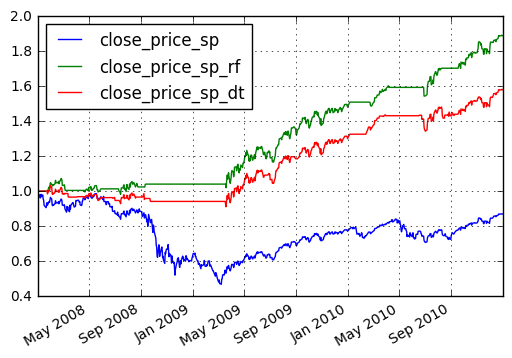

In [114]:
# Graph results ...  normalized trade data frame with start and end times

#st = test_st
#et = test_et

#st = dt.datetime(2000,1,1)
#et = dt.datetime(2003,12,31)

#st = dt.datetime(2008,6,1)
#et = dt.datetime(2009,12,31)

st = dt.datetime(2008,1,1)
et = dt.datetime(2011,1,1)

#st = dt.datetime(2014,1,1)
#et = dt.datetime(2016,12,31)

print('start date = ',st,'\nend date =',et)

# plot start and end times

pst=st
pet=et

#pst = dt.datetime(2011,1,1)
#pet = dt.datetime(2011,12,31)


# Read

f_sp_dft_rf='dft_sp_ndt40_2000_2017412_RF.csv'
f_sp_dft_dt='dft_sp_ndt40_2000_2017412_DT.csv'
f_AAPL_dft_rf='dft_AAPL_ndt45_2011_2017412_RF.csv'
f_AAPL_dft_dt='dft_AAPL_ndt45_2008_2017412_DT.csv'

dft_sp_rf= pd.read_csv(f_sp_dft_rf,index_col=0,parse_dates=True)
dft_sp_dt= pd.read_csv(f_sp_dft_dt,index_col=0,parse_dates=True)

dft_AAPL_rf= pd.read_csv(f_AAPL_dft_rf,index_col=0,parse_dates=True)
dft_AAPL_dt= pd.read_csv(f_AAPL_dft_dt,index_col=0,parse_dates=True)

dft_sp_rf.loc[dft_sp_rf.index[0],'close_price_SP']=dft_sp_rf.loc[dft_sp_rf.index[0],'close_price']
dft_sp_dt.loc[dft_sp_dt.index[0],'close_price_SP']=dft_sp_rf.loc[dft_sp_dt.index[0],'close_price']

# Normalize
dftn=dft_sp_rf.loc[st:et,['close_price','close_price_SP']]/dft_sp_rf.loc[dft_sp_rf.index[0],'close_price'].copy()
dftn_i0=dftn.index[0]
dftn['close_price_sp']=dftn['close_price']/dftn.loc[dftn_i0,'close_price']
dftn['close_price_sp_rf']=dft_sp_rf.loc[st:et,'close_price_SP']/dft_sp_rf.loc[dftn_i0,'close_price_SP']
dftn['close_price_sp_dt']=dft_sp_dt.loc[st:et,'close_price_SP']/dft_sp_dt.loc[dftn_i0,'close_price_SP']
del dftn['close_price_SP']
del dftn['close_price']

if st >= dt.datetime(2008,6,1):
    dftn_AAPL=dft_AAPL_dt.loc[st:et,['adj_close_price','adj_close_price_SP']]
    dftn_AAPL_i0=dftn_AAPL.index[0]
    dftn_AAPL['adj_close_price_AAPL']=dftn_AAPL['adj_close_price']/dftn_AAPL.loc[dftn_AAPL_i0,'adj_close_price']
    dftn_AAPL['adj_close_price_AAPL_dt']=dft_AAPL_dt.loc[st:et,'adj_close_price_SP']/dft_AAPL_dt.loc[dftn_AAPL_i0,'adj_close_price_SP']
    del dftn_AAPL['adj_close_price_SP']
    del dftn_AAPL['adj_close_price']
    
if st >= dt.datetime(2011,1,1):
    dftn_AAPL['adj_close_price_AAPL_rf']=dft_AAPL_rf.loc[st:et,'adj_close_price_SP']/dft_AAPL_rf.loc[dftn_AAPL_i0,'adj_close_price_SP']


# Graph Results
dftn.loc[pst:pet,['close_price_sp','close_price_sp_rf','close_price_sp_dt']].plot(grid=True)


if st >= dt.datetime(2008,6,1):
    dftn_AAPL.loc[pst:pet,['adj_close_price_AAPL','adj_close_price_AAPL_dt','adj_close_price_AAPL_rf']].plot(grid=True)




In [398]:
# http://chrisstrelioff.ws/sandbox/2015/06/08/decision_trees_in_python_with_scikit_learn_and_pandas.html


dotf = "dt.dot"
def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open(dotf, 'w') as f:
        export_graphviz(tree, out_file=f,
                        feature_names=feature_names)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")
        

# the following command will export "dt.dot" file
visualize_tree(clf, X.columns)

# run the following command in the directory contaning "dt.dot" file
# > dot -Tpng dt.dot -o dt.png
# > open dt.png

## References

- Find stocks, [Kiplinger 8 Stocks](http://www.kiplinger.com/slideshow/investing/T052-S003-8-stocks-to-buy-now-for-2017/index.html)

- Kiplingers, "10 Great Stocks for the Next 10 Years", December 2016,   PNRA, ADBE, DHR, FBHS, IDXX, LGF

- Kiplingers, "8 Stocks to buy for now", Jan 2017, GOOG, CMD, AAPL, MEDP

- Kiplingers, "My Top Stock Picks for 2017," Jan 2017, AMZN, CVU, SBUX, CRM

- Other stocks, BRK.B, ^GSPC, KO

- Stanford ML CS229 Trend Stock Prediction,  [Stanford CS229 ML Stock Prediction](http://cs229.stanford.edu/proj2013/DaiZhang-MachineLearningInStockPriceTrendForecsting.pdf) ... **ML Features** PE ratio, PX volume, PX ebitda, current enterprise value, 2-day net price change, 10-day volatility, 50-day moving average, 10-day moving average, quick ratio, alpha overridable, alpha for beta pm, beta raw overridable, risk premium, IS EPS, and corresponding S&P 500 index
- CS229 Stock Prediction Feature Selection, ...  http://cs229.stanford.edu/proj2014/Xinjie%20Di,%20Stock%20Trend%20Prediction%20with%20Technical%20Indicators%20using%20SVM.pdf  ... 

- Stanford ML CS229 Text/Article Stock Prediction, [CS229 Bryce Taylor](http://cs229.stanford.edu/proj2013/Taylor-Applying%20Machine%20Learning%20to%20Stock%20Market%20Trading.pdf)
    
- Stock correlations, [Asset Correlations](https://www.portfoliovisualizer.com/asset-correlations)
    
- Example noteboek, [Python Clustering](http://brandonrose.org/clustering)

- Where to get financial data, Quroa - Intrinio, <https://www.quora.com/What-are-some-cheaper-alternatives-to-Bloomberg-data-terminal>

- Intrino, <https://intrinio.com> ... <http://blog.intrinio.com/intrinio-financial-data-in-r-and-rstudio/>  ... API  <http://blog.intrinio.com/stock-api-developers/> ...  <http://docs.intrinio.com>  ... Python Github https://github.com/nhedlund/intrinio .... http://docs.intrinio.com/tags/intrinio-public#data-point .... Converasation with Andrew Carpenter, Intrinio.com ... What I used R for, which I bet you can do better in Python, is to pull in historical prices and then a vector of historical explainatory variables on the same time period. I automated it, and filled forward the quarterly data to match the daily data. Which is the standard in the industry, I learn from my professors. So that gives you a nice clean data frame with as many explainatory variables as you want- valuation metrics, earnings, economic indicators like SPY and VIX. acarpenter@intrinio.com 727-331-3416. ... from the API page  <http://blog.intrinio.com/stock-api-developers/>  good info plus make sure to watch the video. Entire price history using "price" endpoint "https://inntrinio.com/prices?ticker=AAPL" includes 13 data points open, close, adj_high, ... volume  ... use datapoint function to pull in specific data points "https://inntrinio.com/datapoint?ticker=AAPL&item=close_price" ... use the "historical_data" endpoint to pull in time-series "https://inntrinio.com/historical_data?ticker=AAPL&item=pricetoearnings&start_date=2014-01-01&end_date_2015-01-01" ... you can also add in a frequency as "&frequency=yearly"   (yearly, quarterly, monthly, weekly, daily) ... or just the start_date ... **Historical Data Features**  <http://docs.intrinio.com/tags/intrinio-public#historical-data> ... **Modeling financial data in R** ... http://blog.intrinio.com/modeling-financial-data-in-r-with-intrinio/